In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

In [2]:
# Load the preprocessed data
file_path = 'cleaned_online_retail_data.csv'  # Path to the exported .csv
data = pd.read_csv(file_path)

# Inspect the first few rows
print("Initial Data:")
print(data.head())

Initial Data:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country Day of Week  \
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom     Tuesday   
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom     Tuesday   
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom     Tuesday   
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom     Tuesday   
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom     Tuesday   

   Time of Day  Total Revenue  
0            7           83.4  
1            7           81.0  
2            7          

In [3]:
# 1) Select Relevant Features for Clustering
features = ['Total Revenue', 'Quantity', 'Time of Day']

# Clean data: Handle missing values and filter out negative quantities or revenues
data = data.dropna(subset=features)
data = data[(data['Total Revenue'] >= 0) & (data['Quantity'] > 0)]

# Cap outliers at the 99th percentile for robust clustering
for feature in features:
    upper_limit = data[feature].quantile(0.99)
    data = data[data[feature] <= upper_limit]

In [4]:
# 2) Standardize the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features])

# Reduce dataset size for DBSCAN (else, it will be too computationally expensive)
sample_size = 5000  
if X_scaled.shape[0] > sample_size:
    sample_indices = np.random.choice(X_scaled.shape[0], sample_size, replace=False)
    X_scaled_sample = X_scaled[sample_indices]
    data_sample = data.iloc[sample_indices].reset_index(drop=True)
else:
    X_scaled_sample = X_scaled
    data_sample = data

In [5]:
# 3) Reduce Dimensionality with PCA (if not already done)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled_sample)

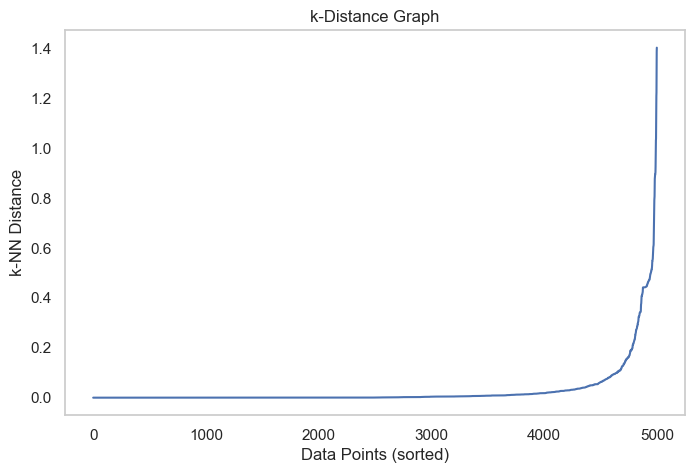

In [6]:
# 4) Determine Optimal Epsilon Using k-Nearest Neighbors
nearest_neighbors = NearestNeighbors(n_neighbors=5)
neighbors = nearest_neighbors.fit(X_reduced)
distances, indices = neighbors.kneighbors(X_reduced)

# Sort and plot k-distance graph
distances = np.sort(distances[:, -1])  # Sort by the k-th nearest neighbor
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('k-Distance Graph')
plt.xlabel('Data Points (sorted)')
plt.ylabel('k-NN Distance')
plt.grid()
plt.show()

# Choose an epsilon value based on the graph
optimal_eps = 0.5

In [7]:
# 5) Apply DBSCAN
dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
data_sample['DBSCAN_Cluster'] = dbscan.fit_predict(X_reduced)

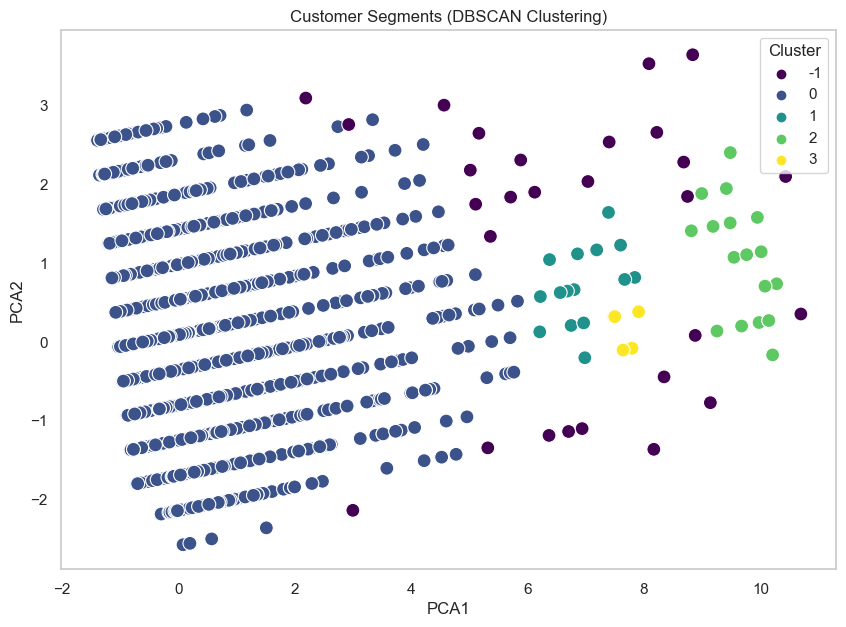

In [8]:
# 6) Visualize DBSCAN Clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    hue=data_sample['DBSCAN_Cluster'],
    palette='viridis',
    s=100,
)
plt.title('Customer Segments (DBSCAN Clustering)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

In [9]:
# 7) Analyze DBSCAN Results
dbscan_cluster_summary = data_sample.groupby('DBSCAN_Cluster')[features].mean()
dbscan_cluster_summary['Num Customers'] = data_sample['DBSCAN_Cluster'].value_counts()
print("DBSCAN Cluster Profiles:")
print(dbscan_cluster_summary)

# Handle noise points labeled as -1
noise_points = data_sample[data_sample['DBSCAN_Cluster'] == -1]
print(f"\nNumber of noise points: {len(noise_points)}")

# Ensure '-1' (noise) cluster is excluded from meaningful analysis
valid_clusters = dbscan_cluster_summary[dbscan_cluster_summary.index != -1]

# Calculate overall averages for reference
overall_avg_revenue = valid_clusters['Total Revenue'].mean()
overall_avg_quantity = valid_clusters['Quantity'].mean()

# Marketing Suggestions for each cluster
for cluster, stats in valid_clusters.iterrows():
    print(f"\nCluster {cluster} Marketing Strategy:")
    print(f" - Avg Revenue: £{stats['Total Revenue']:.2f}")
    print(f" - Avg Quantity: {stats['Quantity']:.2f}")
    print(f" - Peak Engagement Time: {stats['Time of Day']:.2f} (Hour)")
    
    # High Revenue Segment
    if stats['Total Revenue'] > overall_avg_revenue:
        print(" - High Revenue Segment: Consider exclusive discounts, loyalty programs, or premium product recommendations.")
    else:
        print(" - Low Revenue Segment: Recommend popular, budget-friendly, or promotional offers.")
    
    # High Quantity Buyers
    if stats['Quantity'] > overall_avg_quantity:
        print(" - High Purchase Volume: Offer bulk purchase discounts or subscription models.")
    else:
        print(" - Low Purchase Volume: Encourage repeat purchases with personalized follow-ups or small perks.")

# Analyze Noise Points (Cluster -1)
if -1 in dbscan_cluster_summary.index:
    noise_stats = dbscan_cluster_summary.loc[-1]
    print("\nAnalysis for Noise Points (Cluster -1):")
    print(f" - Avg Revenue: £{noise_stats['Total Revenue']:.2f}")
    print(f" - Avg Quantity: {noise_stats['Quantity']:.2f}")
    print(f" - Peak Engagement Time: {noise_stats['Time of Day']:.2f} (Hour)")
    print(" - Noise points may indicate irregular or low-value customers. Consider targeting these customers with re-engagement campaigns or excluding them from high-value segment analysis.")


DBSCAN Cluster Profiles:
                Total Revenue   Quantity  Time of Day  Num Customers
DBSCAN_Cluster                                                      
-1                 133.198571  67.428571    13.285714             28
 0                  15.546755   8.631472    12.804061           4925
 1                 132.370000  68.850000    12.050000             20
 2                 170.529091  99.272727    11.863636             22
 3                 155.616000  67.200000    10.600000              5

Number of noise points: 28

Cluster 0 Marketing Strategy:
 - Avg Revenue: £15.55
 - Avg Quantity: 8.63
 - Peak Engagement Time: 12.80 (Hour)
 - Low Revenue Segment: Recommend popular, budget-friendly, or promotional offers.
 - Low Purchase Volume: Encourage repeat purchases with personalized follow-ups or small perks.

Cluster 1 Marketing Strategy:
 - Avg Revenue: £132.37
 - Avg Quantity: 68.85
 - Peak Engagement Time: 12.05 (Hour)
 - High Revenue Segment: Consider exclusive discounts, 